# **Introdução**

Este é o terceiro projeto feito por mim em função do Bootcamp de Data Science aplicada da Alura. Nele usarei os processos de análise e manipulação de dataframes em conjunto com ferramentas gráficas para analisar séries temporais, inicialmente comparando a evolução no número de casos no estado do Rio de Janeiro com a evolução no número de Casos na cidade de Berlim, Alemanha. Em seguida, utilizarei-me de métodos estatíticos e da biblioteca Prophet para formular um modelo preditivo dos novos casos de Covid-19 no estado do Rio de Janeiro.

## **Comparação entre Rio de Janeiro e Berlim**

Sendo um típico brasileirinho que sou fiquei e fico indignado com a postura adotada pelas autoridades em relação ao combate à Covid-19 no país: Demora para tomar as primeiras iniciativas preventivas, posicionamento anti-científico, etc. Assim, me veio a ideia de comparar o meu querido estado, Rio de Janeiro, um estado que mesmo enfrentando uma das maiores médias de óbitos a cada 100 mil habitantes na época [[1]](https://brasil.elpais.com/brasil/2021-03-07/rio-de-janeiro-adota-lockdown-envergonhado-enquanto-infeccoes-pela-covid-19-aceleram.html) demorou a tomar medidas como o lockdown, com outro grande centro urbano que aplicou com eficácia a prática de lockdown e testar a hipótese de que essa medida realmente poupa vidas. Essa ideia ficou ainda mais interessante pois a Alemanha passou de exemplo ao combate da doença, durante a primeira onda de Covid-19, para um exemplo de como a falsa sensação de segurança e o relaxamento das medidas podem condenar parte da população e fazer subirem drasticamente os índices de casos e mortes[[2]](https://brasil.elpais.com/sociedad/2020-12-17/como-a-alemanha-passou-de-exemplo-na-pandemia-a-um-dos-paises-mais-golpeados-pela-covid-19-na-europa.html).

O dataframe que obtive com os dados de Berlim contava com um índice específico: novos casos a cada 100 mil habitantes nas duas últimas semanas, calculados semanalmente, então manipulei o dataframe que possuia para o estado do Rio de Janeiro a fim de gerar esse índice e poder comparar ambos os Estados. Assim, pude comparar os índices de novos casos a cada 100 mil habitantes de ambos os estados e testar a hipótese de que as medidas de afastamento social são eficazes e necessárias no combate de uma doença de fácil transimssão como é a Covid-19. Finalmente, pude também comparar o índice anteriormente citado no momento em que Berlim passava por uma crise durante a segunda onda com os do Rio de Janeiro.


# **Dados**

Os dados utilizados neste projeto foram obtidos do [Brasil.io](https://brasil.io/dataset/covid19/caso_full/), que disponibiliza dados sobre os casos e óbitos relacionados à Covid-19 no Brasil, e também do [ European Centre for Disease Prevention and Control ](https://www.ecdc.europa.eu/en/covid-19/data), que fornece dados quanto ao combate da Covid-19 em diversos países dentro da União Européia.
Eu escolhi os dataset: 
- caso_full, que possui os dados para todos os municípios do país.
- Data on the weekly subnational 14-day notification rate of new COVID-19 cases[[3]](https://www.ecdc.europa.eu/en/publications-data/weekly-subnational-14-day-notification-rate-covid-19), que possui o índice de novos casos a cada 100 mil habitantes das últimas 2 semanas, feito semanalmente, de uma grande gama de estados de diversas nações dentro da União Européia.

Ambos irão ser disponibilizados no repositório do projeto no GitHub.



# **Hipóteses**

- A prática de medidas de afastameto social bem aplicadas reduzem a propagação do Covid-19.

- O número de casos no Rio de Janeiro deve diminuir por conta do início da campanha de vacinação.

# **Estrutura do notebook:**

- Importação das bibliotecas usadas.

- Importação dos dados.

- Tratamento dos dados para comparação entre RJ e Berlim.

- Primeira análise dos dados.

- Tratamento dos dados para uso do Prophet.

- Construção de um modelo preditivo.

 - Previsão de novos casos no RJ.
 
- Comentários sobre o modelo.
 
- Conclusões.

- Projeções futuras.


# Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
import matplotlib
from matplotlib import transforms
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans, ztest
from scipy.stats import mannwhitneyu

# Importando os dados

In [2]:
df_europa = pd.read_csv('data(2).csv')

In [3]:
df_caso_full = pd.read_csv('caso_full.csv')

# Primeiro tratamento de dados

In [4]:
#Primeiramente isolando somente os dados referentes ao estado do RJ

df_caso_full_rj = df_caso_full.query('state == "RJ"')

In [5]:
#Retirando os dados referentes à linhas que possuiam a coluna estado com o valor NaN, ou, vazio.

df_caso_full_rj['city'].replace(np.nan, 'a', inplace=True)
df_caso_full_rj = df_caso_full_rj.query('city != "a"')

/home/lulu/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [6]:
#Criando outro dataframe agrupando os dados de todas as cidades para obter os dados do estado como um todo.

df_caso_full_rj_2 = df_caso_full_rj.groupby(['state', 'date']).sum()

In [7]:
#Convertendo o formato de Ano/Semana do dataframe europeu para Ano/Mês/Dia

lista = []

for i in df_europa['year_week']:
    lista.append(datetime.datetime.strptime(i + '-1', "%Y-%W-%w"))
    
df_europa['year_week'] = lista

In [8]:
df_caso_full_rj_2 = df_caso_full_rj_2.reset_index()

In [9]:
#Fazendo o python reconhecer que essa coluna era datetime.

df_caso_full_rj_2['date'] = pd.to_datetime(df_caso_full_rj_2['date'], format='%Y-%m-%d')

In [10]:
#Construindo o índice de novos casos a cada 100 mil habitantes das últimas 2 semanas, calculado semanalmente
#para a cidade do RJ.

taxa = []

for i in range(20,482,7):
    
    soma = 0
    
    for j in range(i-14,i):
        
        soma =  df_caso_full_rj_2['new_confirmed'][i] + soma
    
    conta = (soma/(6748000)) * 100000
    
    taxa.append(conta)

In [11]:
#Criando uma lista com as datas onde os índices foram calculados.

dias = []

for i in range(20,482,7):

    dias.append(df_caso_full_rj_2['date'][i])

In [12]:
#Criando o dataframe com o índice e as datas para a cidade do RJ.

df_taxa_14dias_semanal = pd.DataFrame({'datas':dias, 'taxas_semanais':taxa})

In [13]:
# Fazendo um novo dataframe onde só estivessem os dados da cidade de Berlim.

df_europa_2= df_europa.query('region_name == "Berlin"')

In [14]:
df_caso_full_rj_2['media_movel'] = df_caso_full_rj_2['new_confirmed'].rolling(window=7, center=False).mean()

In [15]:
df_onda1_rj = df_caso_full_rj_2.query('date < "2020-10-01"')['new_confirmed']

In [16]:
df_onda1_ber = df_europa_2.query('year_week < "2020-10-01"')['rate_14_day_per_100k']

# Primeira análise

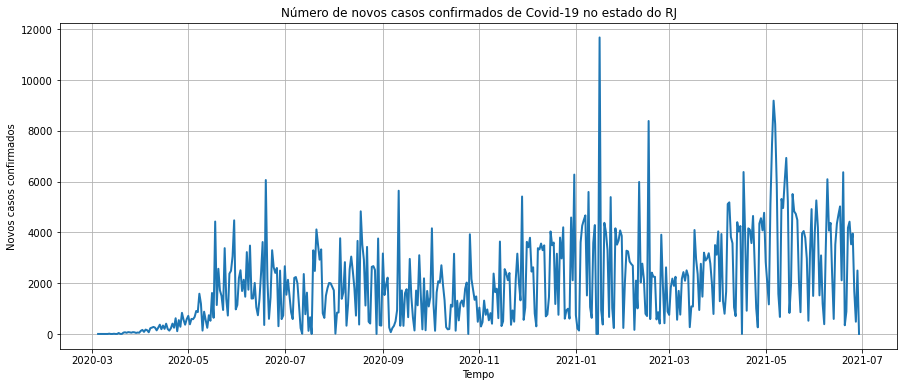

In [17]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.sca(ax)
sns.lineplot(x='date', y='new_confirmed', data=df_caso_full_rj_2, linewidth = 2)
plt.ylabel('Novos casos confirmados')
plt.xlabel('Tempo')
plt.title('Número de novos casos confirmados de Covid-19 no estado do RJ')
plt.grid()
plt.show()

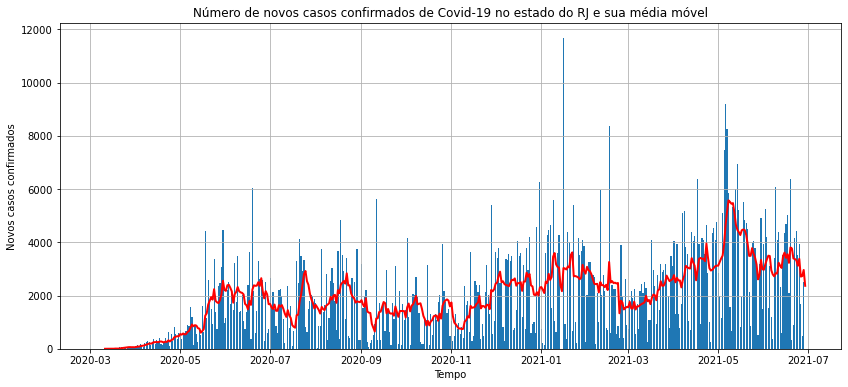

In [18]:
fig, ax = plt.subplots(figsize = (14, 6))
plt.sca(ax)
ax.bar(df_caso_full_rj_2['date'], df_caso_full_rj_2['new_confirmed'])
ax.plot(df_caso_full_rj_2['date'], df_caso_full_rj_2['media_movel'], linewidth = 2, color='red')
plt.ylabel('Novos casos confirmados')
plt.xlabel('Tempo')
plt.title('Número de novos casos confirmados de Covid-19 no estado do RJ e sua média móvel')
plt.grid()
plt.show()

No handles with labels found to put in legend.


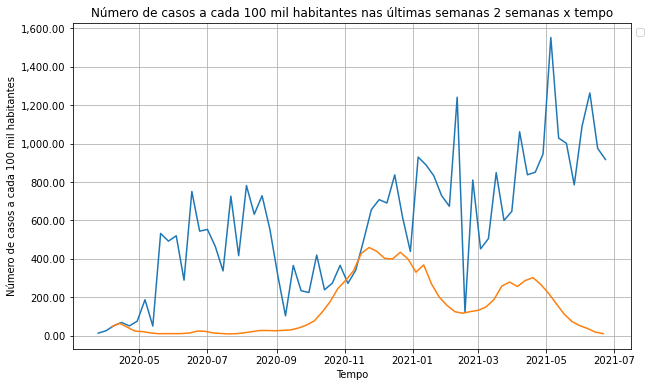

In [19]:
#Plotando o gráfico comparativo entre RJ e Berlim.

plt.figure(figsize=(10,6))
ax = sns.lineplot(x='datas', y='taxas_semanais',data=df_taxa_14dias_semanal)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Tempo')
plt.ylabel('Número de casos a cada 100 mil habitantes')
plt.title('Número de casos a cada 100 mil habitantes nas últimas semanas 2 semanas x tempo')
plt.grid()
sns.lineplot(x='year_week', y='rate_14_day_per_100k',data=df_europa_2)
plt.show()

### Podemos aplicar um simples teste de hipótese também:

Nossa hipótese $H_0$ será a hipótese de que medidas de contenção social não implicam em um menor número de mortes por Covid-19, ou seja: 

$$H_0 : \mu_{berlim} -\mu_{rj} \geq 0 $$

E a hipótese $H_1$ será a hipótese de que elas funcionam, ou seja:

$$H_1 : \mu_{berlim} -\mu_{rj} < 0 $$

Onde :

$\mu_{berlim}$ é a média do índice para a cidade de Berlim e $\mu_{rj}$ é a média do índice para a cidade do Rio de Janeiro.

Rejeitaremos a hipótese $H_0$ se sua probabilidade for menor que a significância. Usarei uma significância de $0.1\%$ aqui.

In [20]:
u, prob = mannwhitneyu(df_onda1_ber,df_onda1_rj,alternative='less')

prob <= 0.01

True

Eu utilizei aqui o teste de hipótese de Mann-Whitney, pois é um teste para quando temos amostragens diferentes para um dos testados e também para quando essas amostragens são pequenas, ou seja, inferiores à 30.

Referência para o [teste de Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).

# Segundo tratamento de dados

In [21]:
#Fazendo listas e um dataframe contendo os feriados do RJ.

feriados_rj_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_rj_2021 = [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]

feriados_rj_2020 = pd.DataFrame({'holiday': 'rj_2020',
                                'ds': pd.to_datetime(feriados_rj_2020)})

feriados_rj_2021 = pd.DataFrame({'holiday': 'rj_2021',
                                'ds': pd.to_datetime(feriados_rj_2021)})

feriados = pd.concat((feriados_rj_2020, feriados_rj_2021))

In [22]:
#Construindo o dataframe para ser passado ao Prophet e um dataframe com os dados do último mês para teste

df = pd.DataFrame()
df['ds'] = df_caso_full_rj_2['date'][:451]
df['y'] = df_caso_full_rj_2['new_confirmed'][:451]
df_teste = pd.DataFrame()
df_teste['ds'] = df_caso_full_rj_2['date'][451:]
df_teste['y'] = df_caso_full_rj_2['new_confirmed'][451:]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

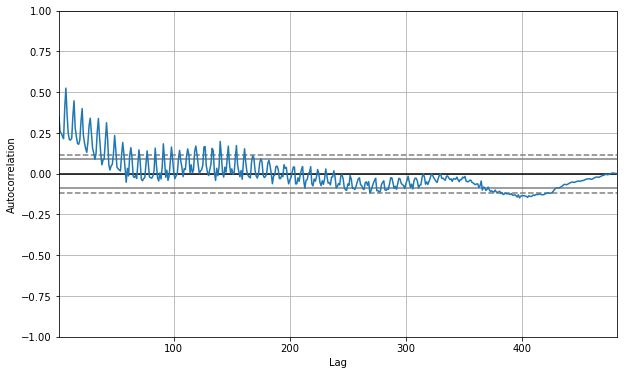

In [23]:
plt.figure(figsize=(10,6))
autocorrelation_plot(df_caso_full_rj_2['new_confirmed'])

# Construção do modelo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


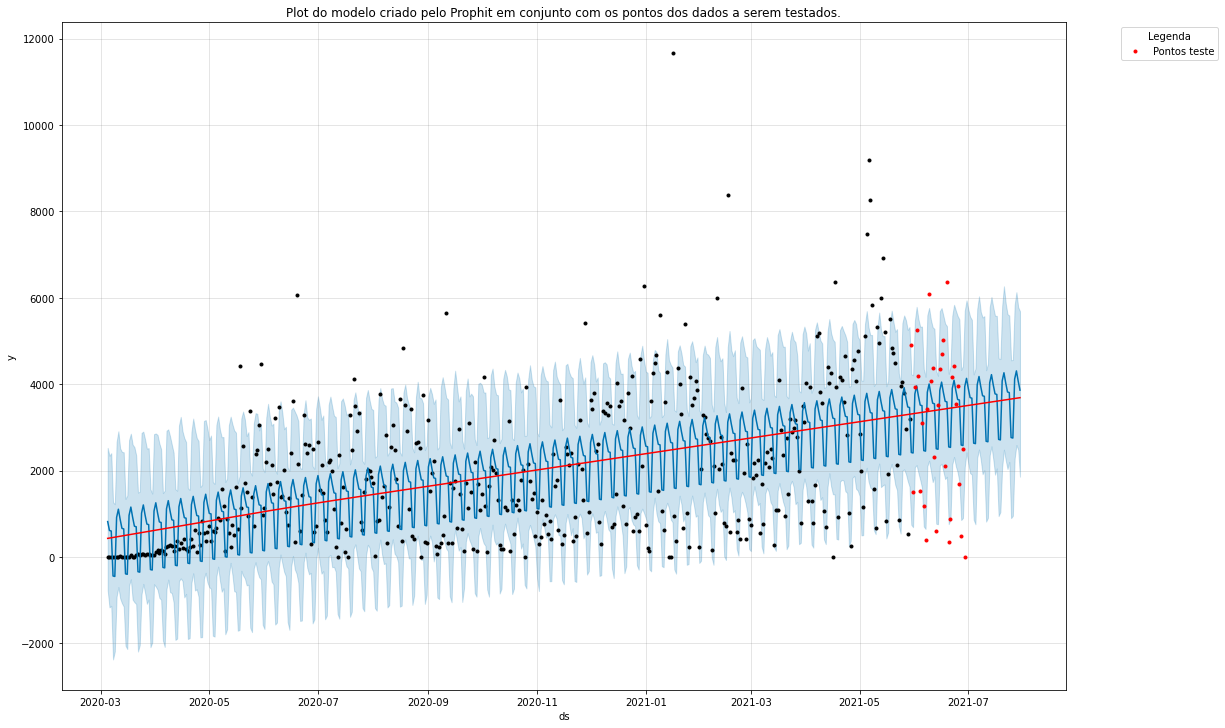

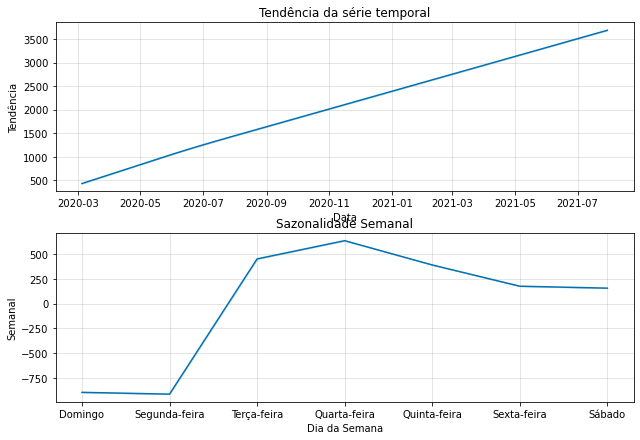

In [24]:
#Começando pelo modelo mais simples possível, temos os seguintes resultados.

modelo_simples = Prophet()
modelo_simples.fit(df)
dff = modelo_simples.make_future_dataframe(periods=62)
prev = modelo_simples.predict(dff)
fig = modelo_simples.plot(prev, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_simples, prev)
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
plt.show()
ax = modelo_simples.plot_components(prev);
eixos = ax.get_axes()
eixos[0].set_title('Tendência da série temporal')
eixos[0].set_ylabel('Tendência')
eixos[0].set_xlabel('Data')
eixos[1].set_title('Sazonalidade Semanal')
eixos[1].set_ylabel('Semanal')
eixos[1].set_xlabel('Dia da Semana')
eixos[1].set_xticks(range(0, 7))
eixos[1].set_xticklabels(['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira'
                         ,'Sábado'])
plt.show()

In [25]:
MAerror = mean_absolute_error(df['y'],prev['yhat'][:len(df)])

r2 = r2_score(df['y'],prev['yhat'][:len(df)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 1039.532503304079 e o R² foi 0.35016009521078306.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


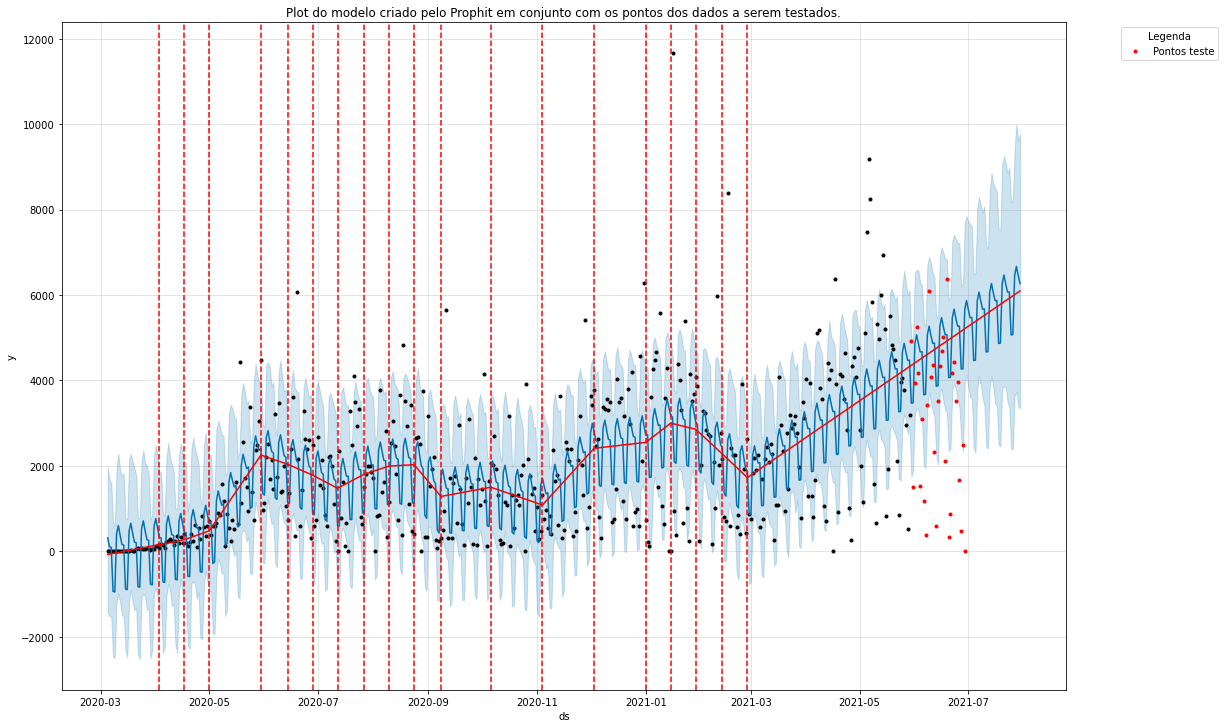

In [26]:
#Mudando o parâmetro changepoint_prior_scale agora.

modelo_simples = Prophet(changepoint_prior_scale=10.0)
modelo_simples.fit(df)
dff = modelo_simples.make_future_dataframe(periods=62)
prev = modelo_simples.predict(dff)
fig = modelo_simples.plot(prev, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_simples, prev)
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
plt.show()

In [27]:
MAerror = mean_absolute_error(df['y'],prev['yhat'][:len(df)])

r2 = r2_score(df['y'],prev['yhat'][:len(df)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 888.2590228025163 e o R² foi 0.4523886163030788.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


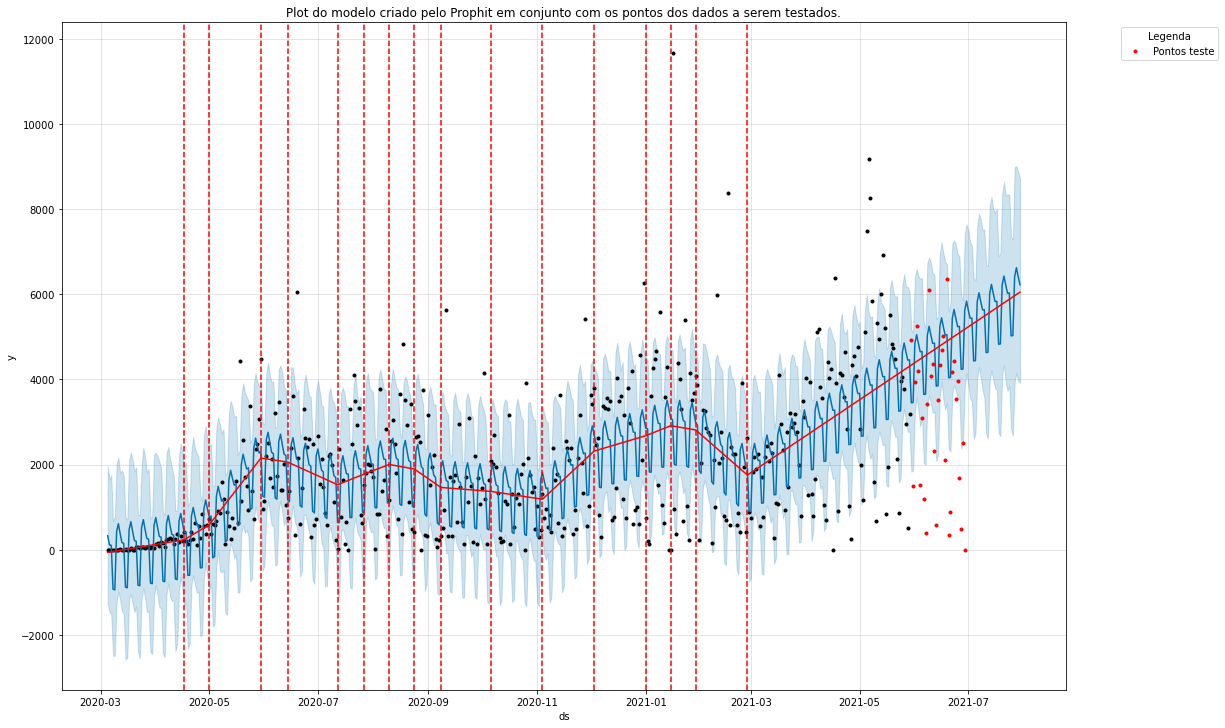

In [28]:
#Testando um valor mais moderado para o parêmtro agora. Decidi continuar com esse valor pois os resultados são
#pouco alterados em precisão, contudo, podemos evitar melhor o problema de overfit.

modelo_simples = Prophet(changepoint_prior_scale=5.0)
modelo_simples.fit(df)
dff = modelo_simples.make_future_dataframe(periods=62)
prev = modelo_simples.predict(dff)
fig = modelo_simples.plot(prev, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_simples, prev)
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
plt.show()

In [29]:
MAerror = mean_absolute_error(df['y'],prev['yhat'][:len(df)])

r2 = r2_score(df['y'],prev['yhat'][:len(df)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 892.1010175687859 e o R² foi 0.4496656970787549.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


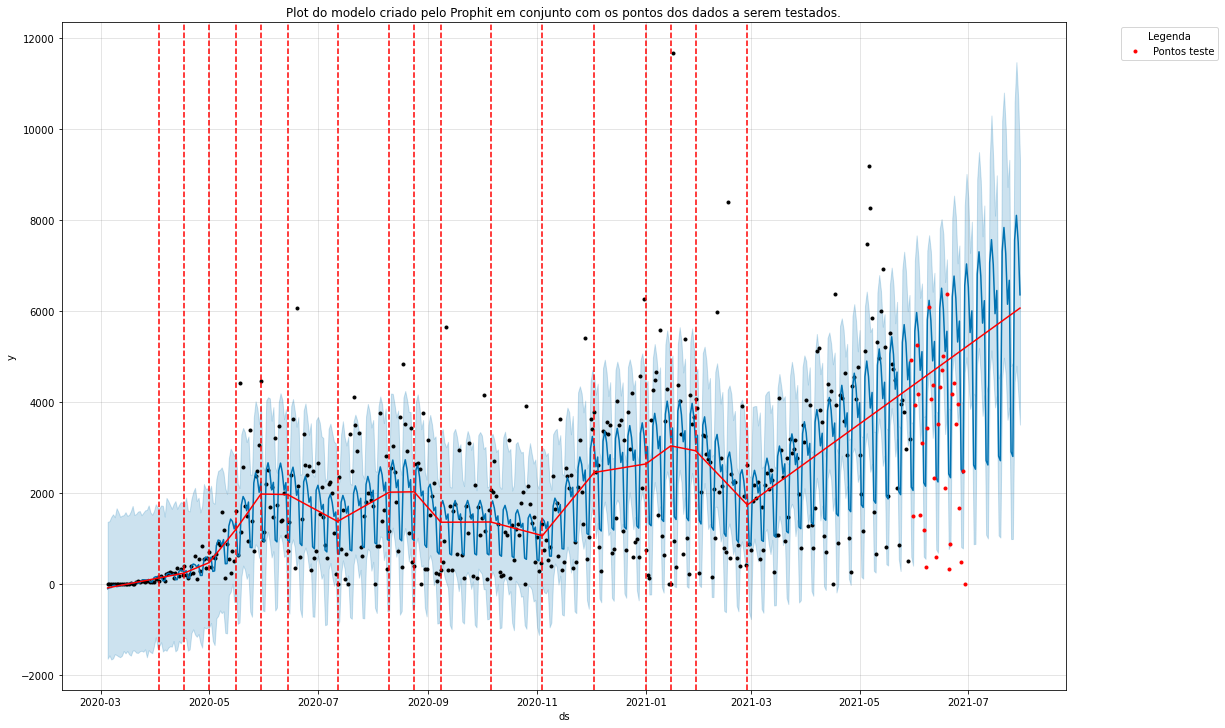

In [30]:
#Aqui atestamos que o modelo com sazonalidade calculada de modo multiplicativo é mais eficiente.

modelo_simples = Prophet(changepoint_prior_scale=5.0, seasonality_mode='multiplicative')
modelo_simples.fit(df)
dff = modelo_simples.make_future_dataframe(periods=62)
prev = modelo_simples.predict(dff)
fig = modelo_simples.plot(prev, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_simples, prev)
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
plt.show()

In [31]:
MAerror = mean_absolute_error(df['y'],prev['yhat'][:len(df)])

r2 = r2_score(df['y'],prev['yhat'][:len(df)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 771.0912453149318 e o R² foi 0.5090792386401264.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


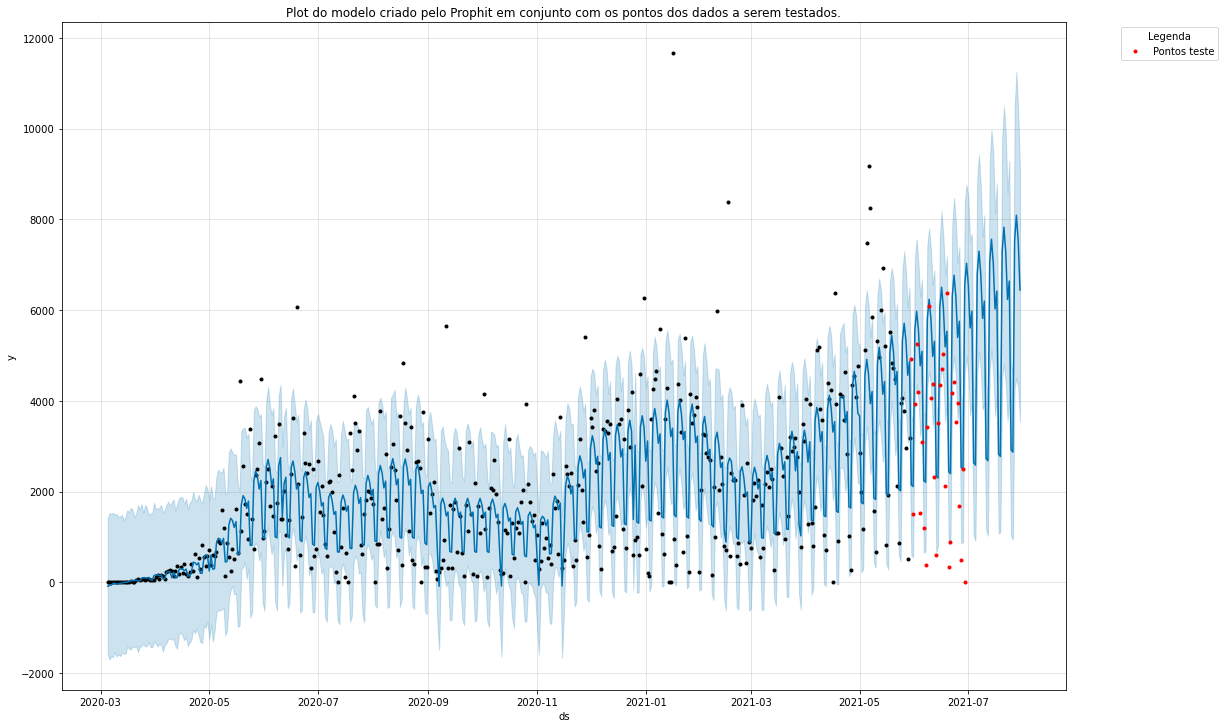

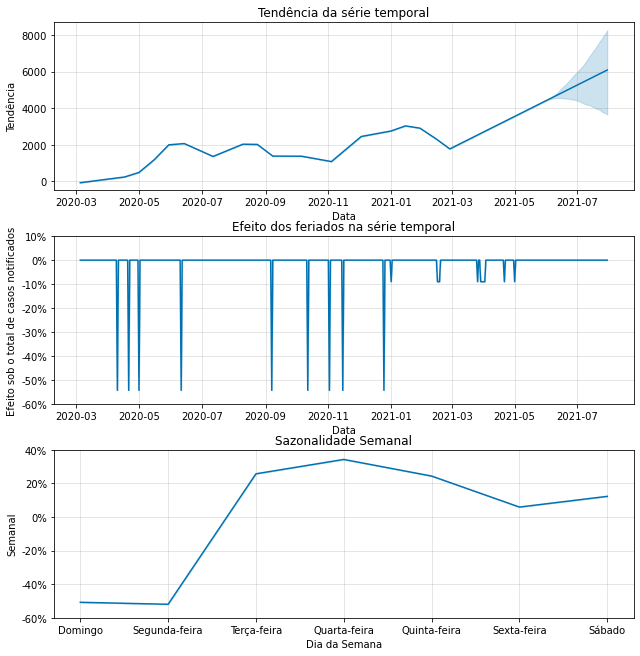

In [32]:
#Aplicando o modelo do prophet no DF criado, fazendo uma previsão de 62 dias no futuro e criando um DF com os dados
#dessa previsão, assim como plotando os gráficos do modelo criado e das componentes destacadas pelo Prophet.
#Esse será o modelo final usado.

modelo_feriados = Prophet(changepoint_prior_scale=5.0, holidays=feriados,
                         seasonality_mode='multiplicative')
modelo_feriados.fit(df)
dff = modelo_feriados.make_future_dataframe(periods=62)
prev = modelo_feriados.predict(dff)
fig = modelo_feriados.plot(prev, figsize=(15,10));
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
plt.show()
ax = modelo_feriados.plot_components(prev);
eixos = ax.get_axes()
eixos[0].set_title('Tendência da série temporal')
eixos[0].set_ylabel('Tendência')
eixos[0].set_xlabel('Data')
eixos[1].set_title('Efeito dos feriados na série temporal')
eixos[1].set_ylabel('Efeito sob o total de casos notificados')
eixos[1].set_xlabel('Data')
eixos[2].set_title('Sazonalidade Semanal')
eixos[2].set_ylabel('Semanal')
eixos[2].set_xlabel('Dia da Semana')
eixos[2].set_xticks(range(0, 7))
eixos[2].set_xticklabels(['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira'
                         ,'Sábado'])
plt.show()

In [33]:
# Usando as métricas de erro absoluta da média e o índice R² para verificar o quão eficaz está sendo meu modelo.

MAerror = mean_absolute_error(df['y'],prev['yhat'][:len(df)])

r2 = r2_score(df['y'],prev['yhat'][:len(df)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 765.3555694455393 e o R² foi 0.513201096687178.


In [34]:
#Criando um dataframe sem outliers

sem_out = df[(df['y'] > prev['yhat_lower'][:451]) & (df['y'] < prev['yhat_upper'][:451])]

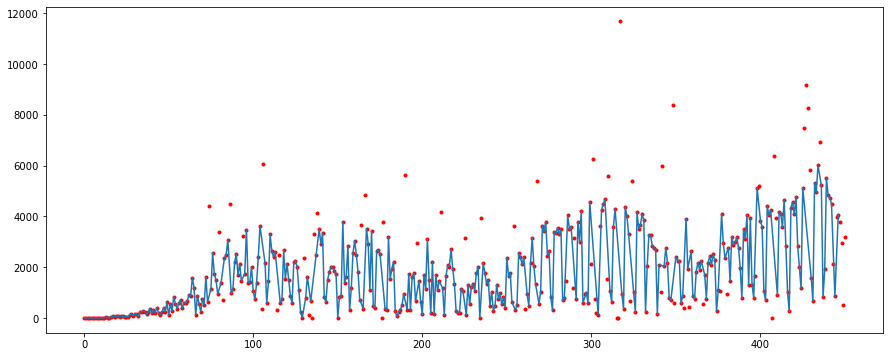

In [35]:
#Plotando um gráfico para vizualizar quais pontos ficaram de fora do novo DF.

plt.figure(figsize=(15,6))
plt.plot(df.index, df['y'], 'r.')
plt.plot(sem_out.index, sem_out['y'])
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


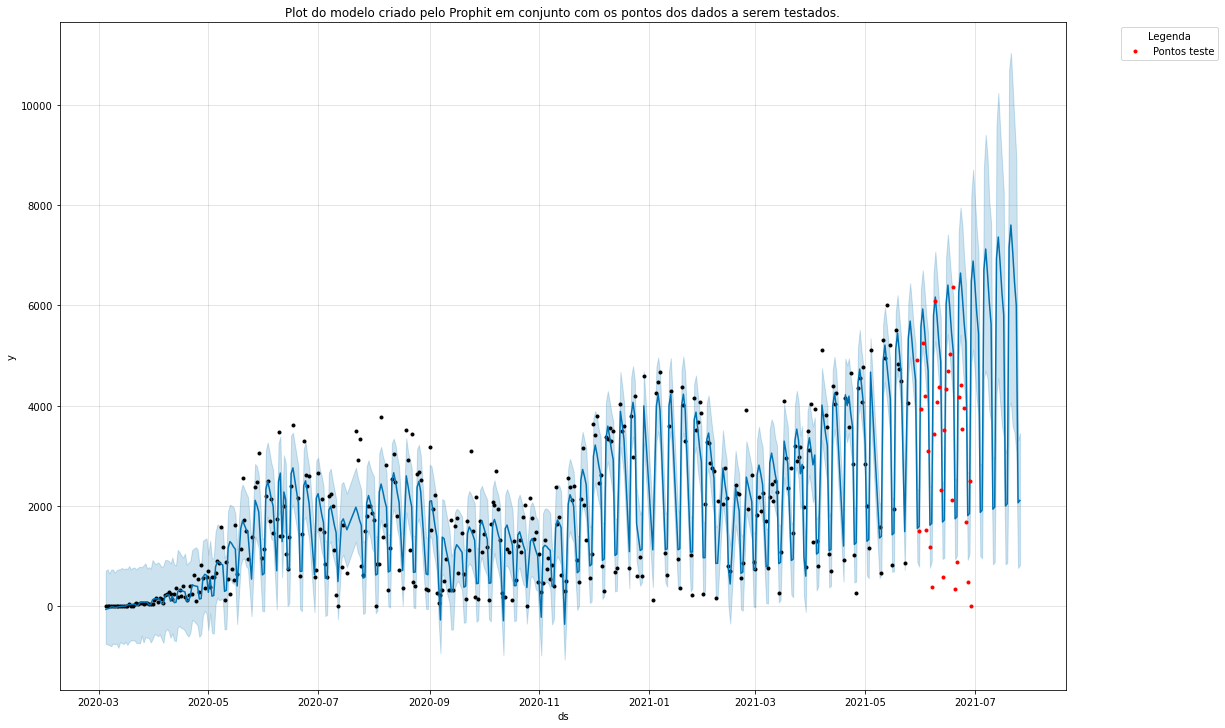

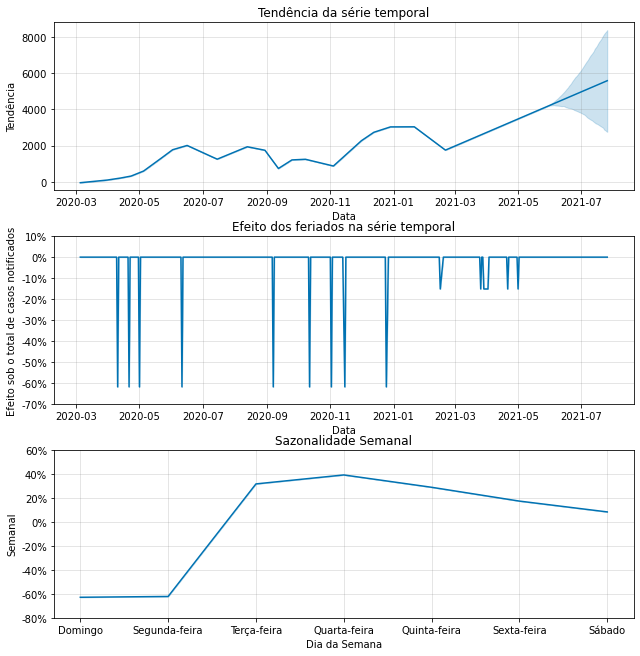

In [36]:
#Aplicando o mesmo modelo e a mesma contrução de gráficos para o novo dataframe sem outliers.

modelo_feriados = Prophet(changepoint_prior_scale=5.0, holidays=feriados,
                         seasonality_mode='multiplicative')
modelo_feriados.fit(sem_out)
dff2 = modelo_feriados.make_future_dataframe(periods=62)
prev2 = modelo_feriados.predict(dff2)
fig = modelo_feriados.plot(prev2, figsize=(15,10));
plt.plot(df_teste['ds'],df_teste['y'],'.r', label='Pontos teste')
plt.legend( title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plot do modelo criado pelo Prophit em conjunto com os pontos dos dados a serem testados.')
ax = modelo_feriados.plot_components(prev2);
eixos = ax.get_axes()
eixos[0].set_title('Tendência da série temporal')
eixos[0].set_ylabel('Tendência')
eixos[0].set_xlabel('Data')
eixos[1].set_title('Efeito dos feriados na série temporal')
eixos[1].set_ylabel('Efeito sob o total de casos notificados')
eixos[1].set_xlabel('Data')
eixos[2].set_title('Sazonalidade Semanal')
eixos[2].set_ylabel('Semanal')
eixos[2].set_xlabel('Dia da Semana')
eixos[2].set_xticks(range(0, 7))
eixos[2].set_xticklabels(['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira'
                         ,'Sábado'])
plt.show()

In [37]:
#As mesmas métricas para os novos resultados

MAerror = mean_absolute_error(sem_out['y'],prev2['yhat'][:len(sem_out)])

r2 = r2_score(sem_out['y'],prev2['yhat'][:len(sem_out)])

print(f'O erro sob a média absoluta para os dados de treino foi de {MAerror} e o R² foi {r2}.')

O erro sob a média absoluta para os dados de treino foi de 424.22873609666163 e o R² foi 0.8310633203549873.


In [38]:
#Tendo em vista que o modelo com o dataframe sem outliers obteve mais sucesso passamos para a etapa de cross 
#validation e em seguida análise dos parâmetros estatísticos que o próprio Prophet nos dá.

df_cv = cross_validation(modelo_feriados, initial='180 days', period='30 days', horizon='62 days')
df_p = performance_metrics(df_cv)

INFO:prophet:Making 7 forecasts with cutoffs between 2020-09-25 00:00:00 and 2021-03-24 00:00:00


INFO:prophet:Skipping MAPE because y close to 0


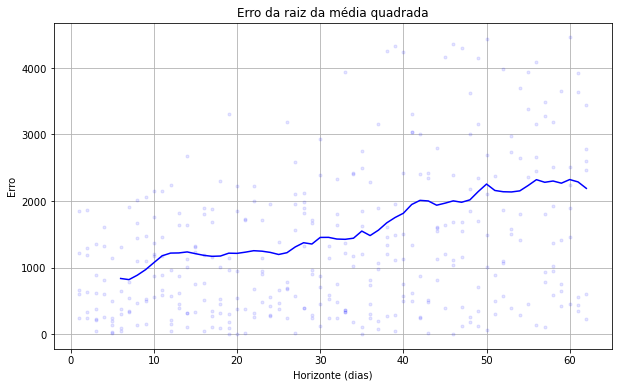

In [39]:
ax = plot_cross_validation_metric(df_cv, metric='rmse');
plt.title('Erro da raiz da média quadrada')
plt.ylabel('Erro')
plt.xlabel('Horizonte (dias)')
plt.show()

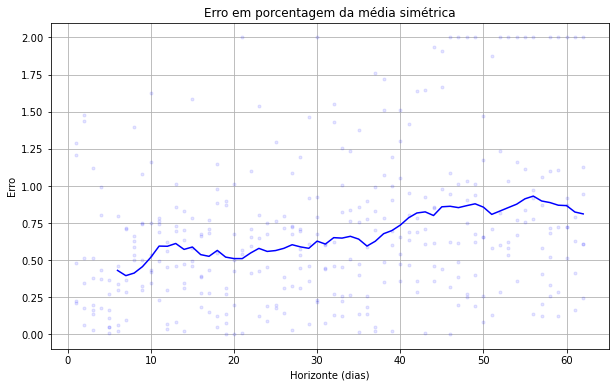

In [40]:
plot_cross_validation_metric(df_cv, metric='smape');
plt.title('Erro em porcentagem da média simétrica')
plt.ylabel('Erro')
plt.xlabel('Horizonte (dias)')
plt.show()

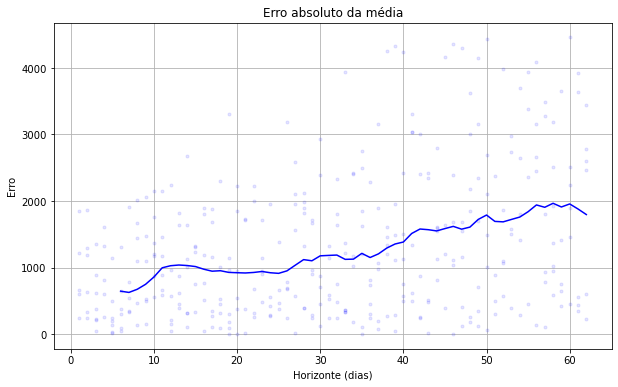

In [41]:
plot_cross_validation_metric(df_cv, metric='mae');
plt.title('Erro absoluto da média')
plt.ylabel('Erro')
plt.xlabel('Horizonte (dias)')
plt.show()

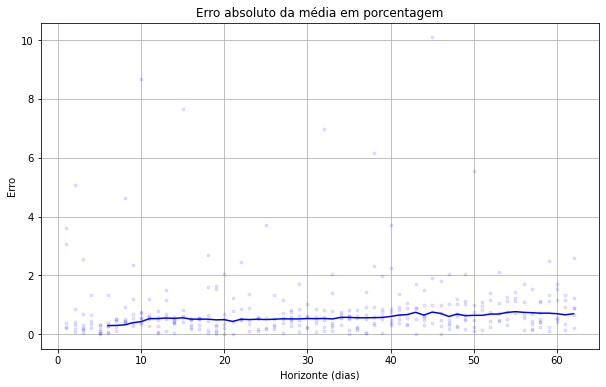

In [42]:
plot_cross_validation_metric(df_cv, metric='mdape')
plt.title('Erro absoluto da média em porcentagem')
plt.ylabel('Erro')
plt.xlabel('Horizonte (dias)')
plt.show()

## **Comentários sobre o modelo**

O primeiro modelo foi criado utilizando o parâmetro change_prior_scale, que muda o quanto o modelo se molda às curvas dos dados, igual à 5 pois é um valor um pouco mais alto que o valor padrão, que é 0.5, assim, gera um fit melhor aos dados, mas evitamos um valor ainda maior para não ocorrer um overfit. Quando tratamos de séries temporais com sazonalidades e padrões o parâmetro de sazonalidade multiplicativa se encaixa melhor. Fora isso, só foram adicionados os feriados. 

Como nossa base de dados é de notificações de casos novos observamos muitas irregularidades e padrões, que até mesmo o Prophet identifica e nos mostra, logo, percebemos que existem pontos muito fora do padrão.Tendo isso em vista, é feito um recorte de outlier para criarmos um modelo mais preciso e os outliers foram selecionados como aqueles valores que se encontravam fora do intervalo de confiança, ou incerteza, alcançada pelo primeiro modelo.

Assim, comparados as quantidades como o R² e o erro absoluto da média, que são quantidades que comparavam o valor previsto com o valor real, vemos que o modelo com outliers removidos gera melhores resultados e então seguimos com ele.

## **Conclusões**

- Observamos a partir do primeiro gráfico, o gráfico que compara o índice de novos casos a cada 100 mil habitantes entre as cidades de Berlim e Rio de Janeiro, que durante a primeira onda o Rio de Janeiro sofre com um grande número de novos casos  e que só para de decrescer em meados de Agosto, enquanto que em Berlim no mesmo período esse índice se encontra estável e com um número de casos bastante inferior, assim, fortalecendo a hipótese de que medidas de isolamento social são eficazes no combate à Covid-19 se bem aplicadas. Aliàdo à análise gráfico temos o teste de hipótese aplicado que corrobora nossa tese.

- Observamos um claro aumento no número de casos em ambos os estados aproximadamente no mês de Outubro de 2020 e Março de 2021, representando as segunda e terceira onda. O Rio de Janeiro, que não conseguiu estabilizar o número de novos casos, sofre com o contínuo aumento desse índice em média, apesar de alguns momentos de descréscimo, já Berlin que relaxou suas medidas sofreu o impacto dessa segunda onda intenssamente, contudo, propôs novas medidas de isolamento social para parar o aumento de novos casos e controlar a crise no estado.

- Para relacionar a diminuição ou o estabilização no índice de novos casos de Covid-19 com a prática de Lockdown ou outras medidas de distanciamento social precisamos analisar também a influência de outras possíveis variáveis nesse índice, tais como o investimento em saúde pública por exemplo. Uma análise muito mais minuciosa e elaborada é feita no artigo [[4]](https://www.nature.com/articles/s41586-020-2404-8.pdf).

- O modelo feito neste trabalho gera previsões razoáveis para até 30 dias além dos dados, contudo, suas taxas de incerteza e erro relacionados as previsões aumentam muito após a faixa de 30 dias de previsão. Assim, à primeira vista poderiamos dizer que é razoável pensar que o índice de novos casos irá crescer no próximo mês, contudo, essa previsão deve ser levada com várias ressalvas devido aos motivos já previamente mencionados e também pelo fator dele não englobar variáveis que podem influenciar esse índice como a própria campanha de vacinação atualmente em curso. Logo, é justo falarmos que a hipótese de que os casos vão diminuir ou até mesmo estabilizar no mês de Julho não é corroborada pelo modelo.

## **Projeções futuras**

- Para analisar melhor a hipótese de que medidas de distanciamento social são eficazes na contenção da Covid-19 podemos fazer uma análise mais parecida com a do artigo previamente mencionado e analisar diversos países que adotaram medidas de proporções diferentes e estudar como evolui o índice de novos casos e óbitos nos mesmos.

- Um melhor estudo sob a biblioteca Prophet se faz necessária para a melhor parametrização do modelo para que assim possamos gerar melhores previsões à cerca da evolução de casos no estado do RJ. 

- Uma outra forma de análise a ser testa pode ser a de separar os dados em amostras de teste e de treino de forma randômica para que assim não precisemos usar os dados do Mês de Junho para teste, logo os englobando e fazendo com que a previsão de 30 dias no futuro englobe todo o mês de Julho, então diminuindo as incertezas e erros relacionados às previsões dos dias que não possuimos dados ainda.


## **Referências**

[[1]](https://brasil.elpais.com/brasil/2021-03-07/rio-de-janeiro-adota-lockdown-envergonhado-enquanto-infeccoes-pela-covid-19-aceleram.html) "Rio de Janeiro adota lockdown envergonhado enquanto infecções pela Covid-19 aceleram".

[[2]](https://brasil.elpais.com/sociedad/2020-12-17/como-a-alemanha-passou-de-exemplo-na-pandemia-a-um-dos-paises-mais-golpeados-pela-covid-19-na-europa.html) "Como a Alemanha passou de exemplo na pandemia a um dos países mais golpeados pela Covid-19 na Europa.

[[3]](https://www.ecdc.europa.eu/en/publications-data/weekly-subnational-14-day-notification-rate-covid-19)"Weekly subnational 14 day notification rate Covid-19"

[[4]](https://www.nature.com/articles/s41586-020-2404-8.pdf)."The effect of large-scale anti-contagion policies on the COVID-19 pandemic"